# IV. Fluorence of a two-level atom

Consider a two-level atom with ground state |g⟩ and excited state |e⟩ driven by a coherent laser field. The Hamiltonian of the two-level atom is 
$\begin{equation}
H=-\frac{\hbar\delta}{2}\sigma_z + \frac{\hbar\Omega}{2}(\sigma_+ + \sigma_-),
\end{equation}$
where $\delta = \omega_L - \omega_0$ is the detuning parameter, $\Omega$ is the Rabi frequency. We will consider $\hbar = 1$ for computional purpose.
With Markovian dissipation accounting for spontaneous emission $\Gamma_e$, the dynamics of the system is governed by the Lindblad master equation
$\begin{equation}
\frac{d\rho_S}{dt} = -\frac{i}{\hbar}[H, \rho_S] + \Gamma_e \left( \sigma_- \rho_S \sigma_+ - \frac{1}{2} \left\{ \sigma_+ \sigma_-, \rho_S \right\} \right).
\end{equation}$

At non-zero temperature, one should replace the dissipative term in Eq. (2) by
$\begin{equation}
\Gamma_e(\bar{n}+1)\left(\sigma_{-}\rho\sigma_{+} - \frac{1}{2} \left\{ \sigma_{+}\sigma_{-}, \rho \right\} \right)+
 \Gamma_e \bar{n} \left(\sigma_{+}\rho\sigma_{-} - \frac{1}{2} \left\{ \sigma_{-}\sigma_{+}, \rho \right\} \right),
\end{equation}$
where $\bar{n} = \left(e^{\hbar \omega_0 / k_B T} - 1\right)^{-1}$  is the mean number of thermal photons of energy $\hbar\omega_0$ at temperature $T$.
When the atom also undergoes pure dephasing at a rate  $\Gamma_d$, the following term must be added to the master
 equation :
$\begin{equation}
\Gamma_d \left( \sigma_z \rho \sigma_z - \frac{1}{2} \left\{ \sigma_z \sigma_z, \rho \right\} \right).
\end{equation}$

### installing & loading packages

In [ ]:
using Pkg

Pkg.add("QuantumOptics")
Pkg.add("CairoMakie")
Pkg.add("LaTeXStrings")
Pkg.add("LinearAlgebra")
Pkg.add("FFTW")
Pkg.add("Plots")
# Pkg.update()

In [14]:
using QuantumOptics
using CairoMakie
using LaTeXStrings
using LinearAlgebra
using FFTW
using GLMakie

import Plots as P
colors=P.palette(:tab10)

## Question 1)

### a) Solving for the *steady-state* density matrix $\rho$ and expressing it in the Bloch sphere

\begin{equation*}
\frac{d\rho_S}{dt} = -\frac{i}{\hbar}[H, \rho_S] + \Gamma_e \left( \sigma_- \rho_S \sigma_+ - \frac{1}{2} \left\{ \sigma_+ \sigma_-, \rho_S \right\} \right).
\end{equation*}

Parameters :

In [7]:
#basis
b = NLevelBasis(2)

#parameters
ω0 = 1                  #Transition frequency between |e> and |g>
ωL = 1                  #Frequency of the Laser
δ = ωL - ω0             #Detuning
Ωs = [0,0.1,0.5,1,5,10] #List of Rabi frequencies
Γe = 1                  #Spontaneous emission rate
Γd = 0                  #Dephasing rate
T = 0;                  #Temperature



0

System :

In [10]:
#System 
b = NLevelBasis(2)
σ_z = transition(b,2,2)-transition(b,1,1)
σ_p = transition(b,2,1)
σ_m = transition(b,1,2)

#Hamiltonian
h(δ,Ω) = -δ/2*σ_z + Ω/2*(σ_p + σ_m) 

#Evolution
tspan = 0:0.05:10
rates = [Γe]
J = [σ_m]

#Spontaneous emission rate depending on T
if T > 0
    n = 1/(exp(ω0/T) - 1)
    rates = [Γe * (n + 1), Γe * n]
    J = [σ_m, σ_p]
end

#Dephasing
if Γd > 0
  push!(rates,Γd)
  push!(J,σ_z)
end;

#Initial state
ψ0 = nlevelstate(b,2)   
ψ0 = tensor(ψ0,ψ0'); 

Evolution of the excited state population depending on time, for different values of $\frac{\Omega}{\Gamma_e}$ :

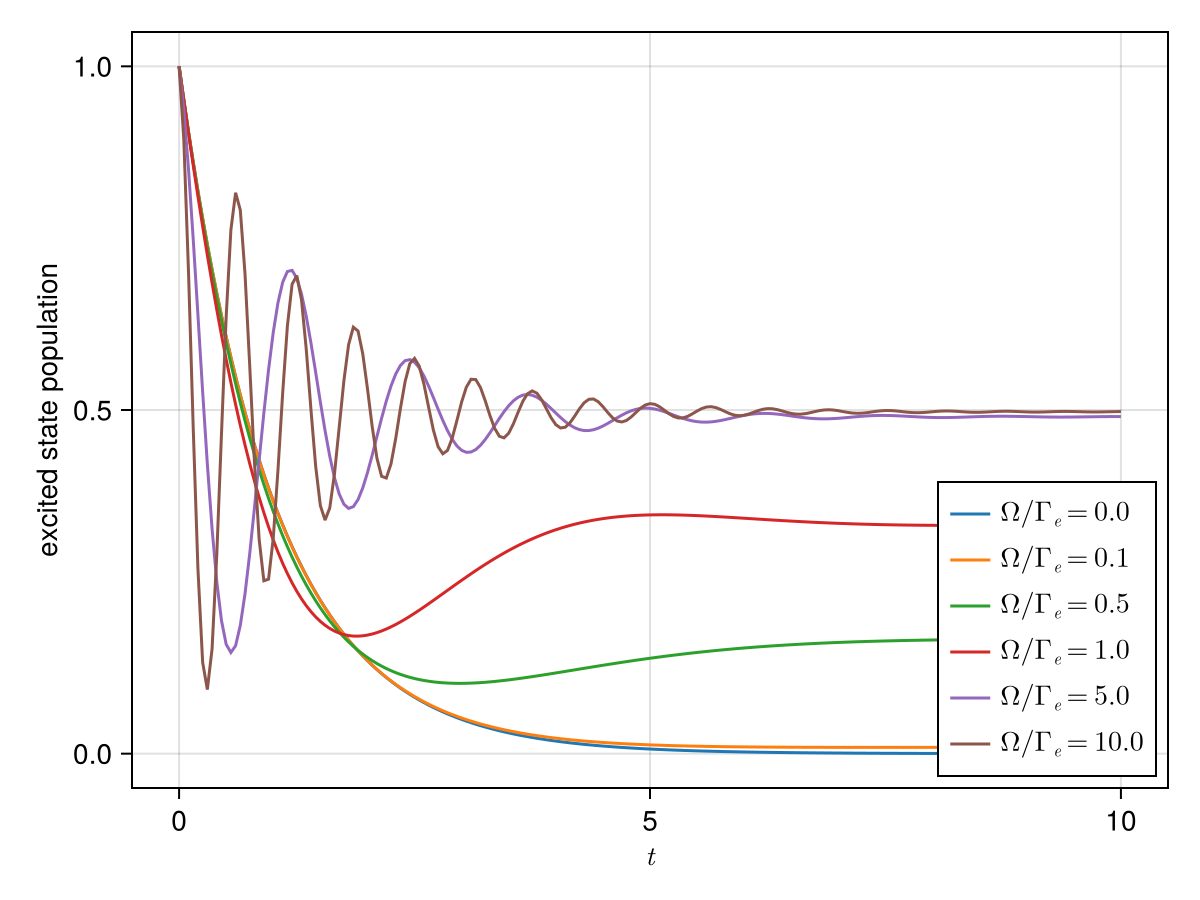

In [12]:
#Figure
CairoMakie.activate!()
fig = Figure()
ax = Axis(fig[1, 1], xlabel=L"t", ylabel="excited state population")

for (i,Ω) in enumerate(Ωs)
    #time evolution
    tout, ψt=timeevolution.master(tspan,ψ0,h(δ, Ω),J; rates)
    #expectation value
    exp_pt=real(expect(transition(b,2,2),ψt))
    #plotting
    lines!(ax, tspan, exp_pt, label=L"\Omega/\Gamma_e = %$(Ω/Γe)",color=colors[i])
end
axislegend(ax,position=:rb)

fig


Bloch ball representation :

In [16]:
#Pauli matrices
σ_x = transition(b,1,2)+transition(b,2,1)
σ_y = im*(transition(b,2,1)-transition(b,1,2))
paulis = [σ_x, σ_y, σ_z]

#Vector to save the position of the Bloch vector
positions = Vector{Vector{Float64}}()
println("Bloch vector norm positions for different values of Ω/Γ_e :")
println("-----------------------------------------------------")
#Steady state 
for (i,Ω) in enumerate(Ωs)
ρ_ss = steadystate.eigenvector(h(δ,Ω), J; rates = rates)
λ = [real(tr(ρ_ss * σ)) for σ in paulis]
println("|λ| = ", norm(λ)," for Ω/Γe = ",Ω/Γe)
push!(positions,λ)
end

#use this command if you want an interactive figure
#GLMakie.activate!()

#Figure
set_theme!(fonts = ( ; regular = "Arial", bold = "Times New Roman Bold"))
x = [p[1] for p in positions]
y = [p[2] for p in positions]
z = [p[3] for p in positions]
figure = Figure(fontsize=24)
axis = Axis3(figure[1, 1], aspect = :data, title="Bloch ball Representation")
#hidedecorations!(axis)
#hidespines!(axis)
sphere = GLMakie.Sphere(Point3f(0), 1)
GLMakie.wireframe!(axis,sphere; linewidth=0.5, color=:orange)
meshscatter!(axis,x,y,z, markersize=0.05)

figure

Bloch vector norm positions for different values of Ω/Γ_e :
-----------------------------------------------------
|λ| = 0.9999999999999992 for Ω/Γe = 0.0
|λ| = 0.9998077477632913 for Ω/Γe = 0.1
|λ| = 0.9428090415820637 for Ω/Γe = 0.5
|λ| = 0.7453559924999296 for Ω/Γe = 1.0
|λ| = 0.19705638472786072 for Ω/Γe = 5.0
|λ| = 0.09962678803234232 for Ω/Γe = 10.0


### b) Computing the number of fluorescence cycles per second 

The number of fluorescence cycles per second is given by $R=\Gamma_e \langle P_e \rangle_{\rho_{ss}}$ with $P_e= \ket{e}\bra{e}$ the population of the excited state.

In [18]:

Ωs=0:0.01:30
δs=[0,0.1,1,5,10]

fig = Figure()
ax = Axis(fig[1, 1], xlabel=L"\Omega/\Gamma_e", ylabel="R",title="Fluorescence cycles per second")
for (j,δ) in enumerate(δs)
    cycles=[]
    cycles_std=[]
    for (i,Ω) in enumerate(Ωs)
        tout, ρ_master = steadystate.master(H(δ,Ω), J)
        push!(cycles,real(expect(transition(b,2,2),ρ_master[end]))*rates[1])
        push!(cycles_std,real(variance(transition(b,2,2),ρ_master[end]))*rates[1])
    end
    lines!(ax, Ωs, cycles, label=L"\delta=%$δ",color=colors[j])
    #error bars
    band!(ax, Ωs, cycles .- cycles_std, cycles .+ cycles_std, color=colors[j], alpha=0.2)
end
Legend(fig[1,2],ax)
display(fig)

GLMakie.Screen(...)

### c) Discussing the graphic, especially the limiting cases when $\Omega = 0$ and $\Omega >> \Gamma_e$

As it was intuitively expected, one can see that the smaller the detuning, the steeper the slope. It is due to the fact that when $\delta -> 0$, it means that thje laser is in resonnace with the atomic transition, so it is normal that the number of excited states growths faster than other values for $\delta$.  
Moreover, concerning the specific case of $\Omega = 0$, it can be seen that there is trivially not any fluorescence cycle occuring, simply because there is no laser driving.  
Finally, when $\Omega >> \Gamma_e$, in function of the detuning $\delta$, the fluorescence rate reaches a horizontal asymptote of a fluorescence cycles rate of 0.5. This value is not suprising as when the system is in its excited state, it quasi-spontaneously comes back down to its ground state, emmiting a photon. 
